###Dataset Overview:

The provided dataset captures monthly energy consumption over a span of 50 years, from June 1970 to May 2020. Each data point consists of the energy consumption value for a specific month.

### Project Summary:

- The project involves time series analysis and machine learning modeling for predicting energy consumption.
- Feature extraction is comprehensive, capturing lag features, rolling statistics, interaction features, seasonal features, rate of change, cumulative sum, EWMA statistics, additional statistics, z-scores, and log returns.
- The Transformer and LSTM model is employed for time series prediction, leveraging its ability to capture temporal dependencies and handle irregular patterns.
- Post-modeling evaluation includes ACF and PACF analysis, Shapiro-Wilk tests, and histogram distribution analysis for residuals.
- Recommendations focus on dynamic feature selection, consistent feature scaling, incorporation of temporal features, and continuous model improvement.

This project demonstrates a holistic approach to time series modeling, combining feature engineering, advanced modeling techniques, and thorough model evaluation.

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [43]:
data_df = pd.read_excel('/content/drive/MyDrive/Energy Consumption.xlsx')
columns_name = ['Energy Consumption']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name
# Seasonal features (assuming you have a time index)
data_df['Time'] = pd.to_datetime(data_df['Time'])
data_df.set_index('Time', inplace=True)

In [44]:
data_df.head()

,Energy Consumption
Time,
1972-04-01,139.546
1972-05-01,137.102
1972-06-01,131.366
1972-07-01,131.361
1972-08-01,140.293


# Task 1 : Feature Extraction
Enhance the features of a time-series energy consumption dataset through comprehensive engineering, crafting a refined dataset tailored for optimal machine learning analysis.

Certainly! Let's provide a brief explanation for each feature:

1. **Lag Features:**
   - Lag features capture the historical values of the energy consumption at different time intervals (lags). They provide insights into the trend and patterns over time.

2. **Rolling Statistics:**
   - Rolling minimum, maximum, mean, and standard deviation features highlight the statistical characteristics of energy consumption over specific rolling windows. They help identify trends, volatility, and outliers.

3. **Interaction Features:**
   - Interaction features combine the moving average and exponential moving average, providing a measure of the combined trend and exponential trend components. This can capture more complex patterns in the data.

4. **Seasonal Features:**
   - Seasonal features, such as quarter and year, help identify patterns and variations in energy consumption that repeat at regular intervals. This is useful for detecting seasonality and understanding how energy usage changes over different periods of the year.

5. **Rate of Change:**
   - Rate of Change features express how much the energy consumption has changed compared to previous time points. It helps in identifying periods of rapid increase or decrease in energy usage.

6. **Cumulative Sum:**
   - Cumulative sum represents the total energy consumption over time, providing a cumulative view of the data. It can highlight overall trends or deviations from the historical average.

7. **Exponential Weighted Moving Average (EWMA) Standard Deviation:**
   - EWMA standard deviation measures the volatility of energy consumption with a focus on recent data points, giving more weight to newer observations. It helps in capturing changes in volatility over time.

8. **Additional Statistics (Lagged Moving Averages, Lagged EMAs, Autocorrelation):**
   - Lagged moving averages and exponential moving averages provide smoothed trends from the past, aiding in identifying longer-term patterns. Autocorrelation measures the correlation between energy consumption at different lags, helping to identify repeating patterns.

9. **Z-Scores:**
   - Z-scores standardize energy consumption data, indicating how many standard deviations a data point is from the mean. Z-scores based on both standard deviation and median absolute deviation provide different perspectives on outliers and deviations from the average.

10. **Log Returns:**
    - Log returns represent the logarithmic change in energy consumption from one time point to the next. They are useful for assessing the percentage change in energy usage and are commonly used in financial analysis.

These features collectively provide a comprehensive set of insights into the temporal patterns, trends, and statistical properties of energy consumption, enabling a more thorough analysis and understanding of the underlying data.

In [45]:
import pandas as pd
import numpy as np

def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['Energy Consumption'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['Energy Consumption'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['Energy Consumption'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['Energy Consumption'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['Energy Consumption'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['Energy Consumption'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['Energy Consumption'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['Energy Consumption'] - data_df['Energy Consumption'].shift(lag)) / data_df['Energy Consumption'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['Energy Consumption'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['Energy Consumption'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['Energy Consumption'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['Energy Consumption'] - data_df['Energy Consumption'].mean()) / data_df['Energy Consumption'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['Energy Consumption'].median()
    mad = np.median(np.abs(data_df['Energy Consumption'] - median))
    data_df['mad_z_score'] = (data_df['Energy Consumption'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['Energy Consumption'] / data_df['Energy Consumption'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 6, 9, 12, 24]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()


In [46]:
data_df_drop.head()

,Energy Consumption,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,moving_median_2,...,autocorr_9,lagged_ma_12,lagged_ema_12,autocorr_12,lagged_ma_24,lagged_ema_24,autocorr_24,z_score,mad_z_score,log_returns
Time,,,,,,,,,,,,,,,,,,,,,
1974-04-01,142.973,149.394,140.852,135.784,142.973,149.394,146.1835,144.097021,4.540333,146.1835,...,0.823143,142.610917,143.939176,0.991084,142.655042,142.911848,0.986716,-1.696873,-2.566243,-0.043931
1974-05-01,140.749,142.973,149.394,140.852,140.749,142.973,141.8610,141.865007,1.572605,141.8610,...,0.823143,143.130583,143.790534,0.991084,142.797833,142.916741,0.986716,-1.729147,-2.609048,-0.015678
1974-06-01,135.833,140.749,142.973,149.394,135.833,140.749,138.2910,137.843669,3.476137,138.2910,...,0.823143,143.530333,143.322606,0.991084,142.949792,142.743321,0.986716,-1.800488,-2.703666,-0.035552
1974-07-01,133.568,135.833,140.749,142.973,133.568,135.833,134.7005,134.993223,1.601597,134.7005,...,0.823143,143.765833,142.170359,0.991084,143.135917,142.190496,0.986716,-1.833357,-2.747260,-0.016815
1974-08-01,142.996,133.568,135.833,140.749,133.568,142.996,138.2820,140.328408,6.666603,138.2820,...,0.823143,143.806750,140.846919,0.991084,143.227875,141.500696,0.986716,-1.696539,-2.565800,0.068206


In [47]:
data_df_drop.tail()

,Energy Consumption,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,moving_median_2,...,autocorr_9,lagged_ma_12,lagged_ema_12,autocorr_12,lagged_ma_24,lagged_ema_24,autocorr_24,z_score,mad_z_score,log_returns
Time,,,,,,,,,,,,,,,,,,,,,
2021-11-01,349.697,400.275,400.116,357.725,349.697,400.275,374.9860,364.424943,35.764047,374.9860,...,0.823143,336.048833,348.041799,0.991084,331.451500,338.448278,0.986716,1.303090,1.412547,-0.135085
2021-12-01,306.670,349.697,400.275,400.116,306.670,349.697,328.1835,325.921648,30.424683,328.1835,...,0.823143,336.204250,348.296445,0.991084,332.118750,339.348175,0.986716,0.678686,0.584412,-0.131295
2022-01-01,301.509,306.670,349.697,400.275,301.509,306.670,304.0895,309.646549,3.649378,304.0895,...,0.823143,335.625667,341.892377,0.991084,332.068792,336.733921,0.986716,0.603790,0.485079,-0.016972
2022-02-01,337.633,301.509,306.670,349.697,301.509,337.633,319.5710,328.304183,25.543525,319.5710,...,0.823143,335.848167,335.679549,0.991084,332.622167,333.915928,0.986716,1.128018,1.180353,0.113160
2022-03-01,334.978,337.633,301.509,306.670,334.978,337.633,336.3055,332.753394,1.877369,336.3055,...,0.823143,337.356333,335.980080,0.991084,333.044375,334.213293,0.986716,1.089489,1.129252,-0.007895


# Task 2 : Feature Selection

Identify and choose the most relevant features from a dataset based on specific evaluation metrics.

The presented code is designed for feature selection and ranking, a crucial step in data analysis and machine learning. The process involves preparing the data, standardizing features, calculating various metrics to assess feature importance, ranking features based on these metrics, and identifying the top features for further analysis.

#### Data Preparation

The initial steps involve converting the original DataFrame, `data_df_drop`, into NumPy arrays. The dataset is then split into input features (`input_data1`) and the corresponding output target (`output_data`).

#### Standardization

To ensure consistency and comparability, both input features and the target variable undergo standardization using the `StandardScaler` from scikit-learn. This step is essential for many machine learning algorithms, as it brings features to a common scale.

#### Feature Metrics Calculation

The code computes several metrics to evaluate feature importance:

1. **F-Statistic (ANOVA):** A statistical method assessing the relationship between the feature and the target variable.
2. **Random Forest Feature Importance:** Utilizing a Random Forest Regressor to evaluate the significance of each feature.
3. **Mutual Information:** Measuring the dependence between features and the target using information theory.
4. **Principal Component Analysis (PCA):** Extracting principal components and their explained variance ratios.

#### Feature Ranking

The `rank_and_top_features` function assigns ranks to each feature based on the calculated metrics and computes a mean rank. The top features are then identified based on this mean rank.

#### Display Top Features

The code concludes by printing the index names of the top-ranked features, assuming the original features are stored in a DataFrame named 'features_df' with 'Time' as the index.

### Conclusion

In summary, this code provides a comprehensive framework for identifying and ranking influential features within a dataset. The selected features can subsequently be employed for more in-depth analysis or used as input features for machine learning models.

In [48]:
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [49]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [50]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index

The top 20 features, as identified and ranked by the feature selection process, provide valuable insights into their significance for the dataset. Here's a brief description of the top features:




Top 20 Features Index:
Index(['Energy Consumption', 'ema_2', 'ema_3', 'mad_z_score',
       'moving_average_12', 'z_score', 'rolling_min_2', 'rolling_max_6',
       'rolling_max_2', 'moving_average_2', 'moving_median_2',
       'moving_average_6', 'rolling_max_12', 'rolling_min_24', 'ema_12',
       'moving_median_12', 'rolling_min_12', 'rolling_min_6',
       'moving_median_6', 'moving_average_24'],
      dtype='object')


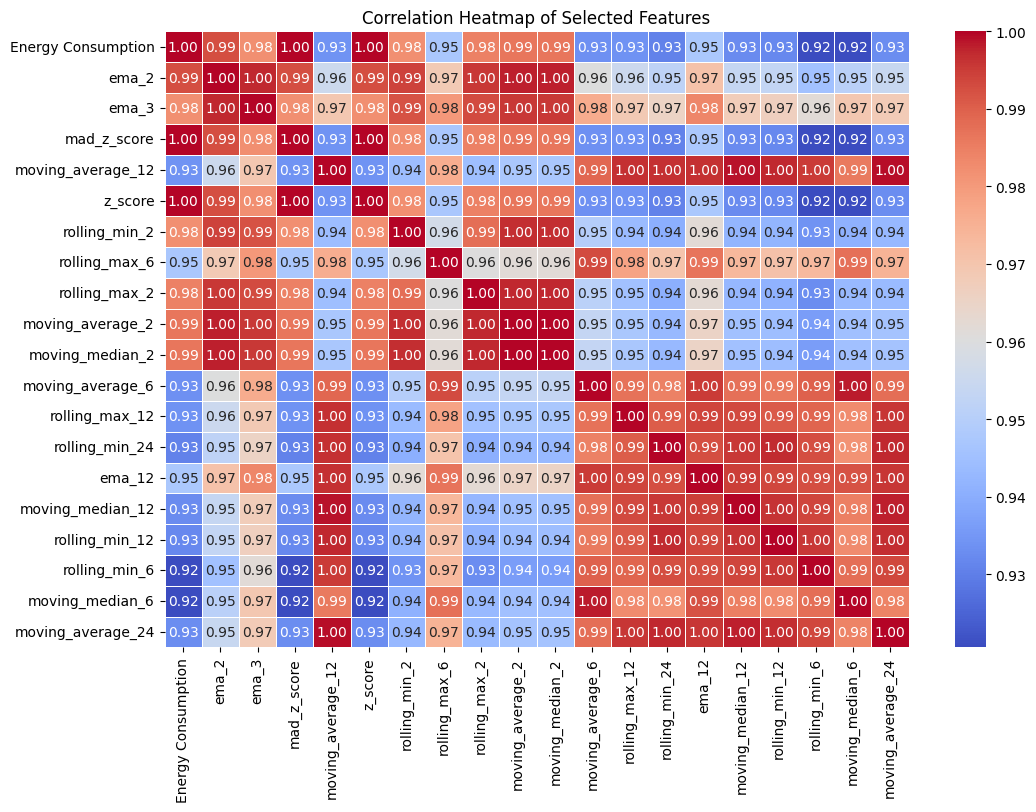

In [51]:
import seaborn as sns
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

These features encompass a diverse set of statistical measures, rolling statistics, and exponential moving averages create a comprehensive representation of the dataset's temporal patterns and trends.







# Task 3: Data Preparation

Implement a comprehensive data preprocessing pipeline using scaling the time series data, generating sequential time series samples (X and y), and conducting a meticulous train-test split.

The "data preprocessing" or "data preparation" stage is a critical phase in the lifecycle of time series analysis or machine learning applications. Its primary goal is to transform raw time series data into a format that is conducive to training and testing machine learning models. In the `prepare_time_series_data` function, several key steps are performed to ensure the data is appropriately processed.

**Scaling Data:**
The first step involves the use of the `StandardScaler` to scale the time series data. This ensures that each feature within the dataset is standardized, having a mean of 0 and a standard deviation of 1. Scaling is crucial as it prevents certain features from dominating the model training process due to differences in their scales.

**Creating Time Series Samples:**
The next crucial task is the generation of time series samples represented by `X` and `y`. The concept here is to create sequences of data points, where each sample in `X` comprises a sequence of time steps. The corresponding value in `y` serves as the target variable, representing the outcome to be predicted. This sequential representation captures the temporal dependencies present in time series data, making it suitable for training models that can learn patterns over time.

**Train-Test Split:**
To assess the model's performance accurately and evaluate its ability to generalize to new, unseen data, the dataset is split into training and testing sets using the `train_test_split` function. This division ensures that the model is trained on a subset of the data and tested on an independent set, simulating real-world scenarios where the model encounters new information.

**Output:**
The function concludes by returning the original time series data (`X`, `y`) along with the prepared training and testing sets (`x_train`, `x_test`, `y_train`, `y_test`). This enables transparency in the workflow and allows for further exploration or analysis of the processed data.

In summary, the meticulous process of scaling, creating time series samples, and performing a train-test split is pivotal for enhancing model performance, aiding in the robust evaluation of models, and facilitating their generalization to unseen data, thereby ensuring the reliability and applicability of machine learning solutions in the context of time series analysis.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_time_series_data(data, time_steps=12, test_size=0.2, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 12
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)


Training set shapes:
(451, 12, 20) (451,)

Testing set shapes:
(113, 12, 20) (113,)


# Task 5: Long Short-Term Memory (LSTM)
Create and execute an LSTM neural network using the Keras library to predict time series data.

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to overcome the limitations of traditional RNNs in capturing long-term dependencies and learning from sequential data. Introduced by Sepp Hochreiter and Jürgen Schmidhuber in 1997, LSTMs have become a fundamental building block in the field of deep learning, particularly for tasks involving sequential or time-series data.

The primary challenge addressed by LSTMs is the vanishing gradient problem, which often occurs in traditional RNNs during the backpropagation process. This problem makes it difficult for RNNs to learn and retain information from distant time steps, hindering their ability to capture long-term dependencies.

LSTMs address this issue by introducing a memory cell and a set of gating mechanisms that control the flow of information within the cell. The key components of an LSTM unit include a cell state, an input gate, a forget gate, an output gate, and a set of activation functions. These components work together to selectively update and utilize the information stored in the cell state, allowing LSTMs to capture and remember relevant information over extended sequences.

The LSTM architecture has proven highly effective in various applications, such as natural language processing, speech recognition, time-series prediction, and more. Its ability to handle long-range dependencies and mitigate the vanishing gradient problem has contributed to its widespread adoption in both research and industry for tasks involving sequential data.

In [53]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K

# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (12 time steps, 20 features)

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/6 [====>.........................] - ETA: 8s - loss: 0.5864 - mae: 0.6037 - r_squared: 0.3542
Epoch 1: val_loss improved from inf to 0.15480, saving model to best_model_lstm.h5
6/6 [==============================] - 2s 75ms/step - loss: 0.3686 - mae: 0.4970 - r_squared: 0.5923 - val_loss: 0.1548 - val_mae: 0.3289 - val_r_squared: 0.8329
Epoch 2/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1491 - mae: 0.3135 - r_squared: 0.8188
Epoch 2: val_loss did not improve from 0.15480
6/6 [==============================] - 0s 16ms/step - loss: 0.1503 - mae: 0.3071 - r_squared: 0.8268 - val_loss: 0.1755 - val_mae: 0.3071 - val_r_squared: 0.8250
Epoch 3/200
1/6 [====>.........................] - ETA: 0s - loss: 0.1401 - mae: 0.2937 - r_squared: 0.8568
Epoch 3: val_loss improved from 0.15480 to 0.13303, saving model to best_model_lstm.h5
6/6 [==============================] - 0s 22ms/step - loss: 0.1332 - mae: 0.2880 - r_squared: 0.8393 - val_loss: 0.1330 - val_mae: 0.30

# Task 4: Transformer

Design and implement a Transformer neural network using the Keras library for the purpose of time series prediction.

The transformer architecture, initially introduced in the context of natural language processing (NLP), has found widespread success and applications in various domains, including time series prediction. Here's a more detailed description of transformers and their applications in time series prediction:

### Transformer Architecture:

1. **Self-Attention Mechanism:**
   - Transformers employ a self-attention mechanism, enabling the model to weigh the importance of different elements in the input sequence when making predictions.
   - Self-attention allows the model to capture long-range dependencies and relationships between distant elements in the sequence.

2. **Positional Encoding:**
   - Transformers do not inherently understand the order of elements in a sequence. Positional encodings, as seen in the `positional_embedding` function, are crucial for providing the model with information about the position of each element in the sequence.

3. **Multi-Head Attention:**
   - Transformers use multiple attention heads to capture different aspects and patterns within the data. Each head focuses on different parts of the input, enhancing the model's ability to learn diverse representations.

4. **Feed-Forward Neural Network:**
   - Following the self-attention mechanism, transformers typically include a feed-forward neural network for further feature extraction and non-linear transformations.

5. **Layer Normalization and Residual Connections:**
   - Layer normalization and residual connections are employed to stabilize training and facilitate the flow of information through the network.

### Applications in Time Series Prediction:

1. **Capturing Temporal Dependencies:**
   - Transformers are well-suited for time series prediction tasks where capturing temporal dependencies is crucial. The self-attention mechanism allows the model to consider the entire historical context when making predictions.

2. **Handling Irregular Patterns:**
   - Time series data often contains irregular patterns, such as varying time intervals between observations. Transformers can effectively handle such irregularities due to their ability to consider the entire sequence simultaneously.

3. **Long-Range Dependencies:**
   - Traditional recurrent neural networks (RNNs) may struggle with capturing long-range dependencies. Transformers excel in this aspect, making them suitable for tasks where understanding relationships between distant data points is essential.

4. **Adaptability to Various Domains:**
   - Transformers have demonstrated versatility across domains, from language translation to image processing and time series prediction. Their adaptability makes them a go-to choice for tasks involving sequential data.

5. **Parallelization:**
   - Transformers allow for efficient parallelization of computation, leading to faster training times compared to some recurrent architectures. This is advantageous, especially when dealing with large time series datasets.

In summary, transformers have become a powerful tool in time series prediction due to their ability to capture complex temporal dependencies, handle irregular patterns, and provide a holistic view of the input sequence. Their success in NLP has paved the way for applications in various domains, showcasing their effectiveness in capturing contextual information from sequential data.

In [54]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape=input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

The provided code implements the training of a transformer-based model for time series prediction using the Keras library. Let's break down the key components:

### Model Architecture:

- **Transformer Model:**
  - The `build_model` function constructs a transformer model with specified parameters such as the number of transformer blocks, head size, number of heads, feed-forward dimensions, etc.
  - It utilizes multi-head self-attention mechanisms, layer normalization, residual connections, and feed-forward neural networks to capture complex temporal dependencies.

- **Custom Metric (R-squared):**
  - The code defines a custom metric function called `r_squared`. This metric measures the goodness of fit and is computed based on the proportion of the variance in the dependent variable (target) that is predictable from the independent variable (predictions).

### Model Compilation:

- The model is compiled using the Mean Squared Error (MSE) as the loss function, Mean Absolute Error (MAE), and the custom R-squared metric as evaluation metrics.
- The Adam optimizer is employed with a specified learning rate.

### Model Training:

- The training is performed using the `fit` method on the training data (`x_train` and `y_train`).
- The training set is split into training and validation subsets using a validation split of 20%.
- The training process runs for 200 epochs with a batch size of 64.
- The `ModelCheckpoint` callback is utilized to save the best model based on validation loss. The best model is saved to the file specified by `checkpoint_filepath`.

### Result:

- The training history is stored in the `history` variable, containing metrics such as loss, mean absolute error, validation loss, and validation mean absolute error for each epoch.

### To Summarize:

The code defines, compiles, and trains a transformer-based model for time series prediction, optimizing for Mean Squared Error while monitoring validation loss. The training progress is saved, and the final model is stored in the file specified by `checkpoint_filepath`. The custom R-squared metric provides additional insight into the model's performance.

In [135]:
from keras.callbacks import ModelCheckpoint
input_shape = x_train.shape[1:]


# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)
# model.summary()

import keras.backend as K

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
6/6 [==============================] - ETA: 0s - loss: 0.7614 - mae: 0.7031 - r_squared: 0.1656
Epoch 1: val_loss improved from inf to 0.33520, saving model to best_model_transformer.h5
6/6 [==============================] - 20s 349ms/step - loss: 0.7614 - mae: 0.7031 - r_squared: 0.1656 - val_loss: 0.3352 - val_mae: 0.4888 - val_r_squared: 0.6265
Epoch 2/200
6/6 [==============================] - ETA: 0s - loss: 0.2182 - mae: 0.3807 - r_squared: 0.7420
Epoch 2: val_loss improved from 0.33520 to 0.21455, saving model to best_model_transformer.h5
6/6 [==============================] - 1s 138ms/step - loss: 0.2182 - mae: 0.3807 - r_squared: 0.7420 - val_loss: 0.2145 - val_mae: 0.3719 - val_r_squared: 0.7746
Epoch 3/200
5/6 [========================>.....] - ETA: 0s - loss: 0.1773 - mae: 0.3409 - r_squared: 0.8012
Epoch 3: val_loss improved from 0.21455 to 0.14433, saving model to best_model_transformer.h5
6/6 [==============================] - 1s 133ms/step - loss: 0.1754 - m

# Task 5: Evaluation


Evaluate the performance of the LSTM and Transformer neural networks on both the test set and the entire dataset by generating plots and calculating regression metrics. Specifically, create plots that compare the true values against the predicted values for both the final test set and the entire dataset. Additionally, compute some regression metrics on them.

The provided code performs various tasks related to the evaluation and visualization of a regression model. In the first section, the standardized target variable is inverse-transformed to obtain the original scale of the target variable (y). This process is repeated for the original target, final predictions on the entire dataset, and final predictions on the test set using the best model.

The second section involves the creation of line plots comparing true and predicted values. These plots visualize how well the model predictions align with the actual target values. One plot is generated for the final test set using the best model, another for the entire dataset, and a third for the final test set.

The third section defines a function (calculate_metrics_and_print) responsible for computing various regression metrics, such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), R-squared, Mean Absolute Error (MAE), Log Likelihood, and Mean Absolute Percentage Error (MAPE). These metrics provide a comprehensive assessment of the model's performance on different datasets. The function is then applied to calculate and print metrics for the original data model, predictions on the final test set, predictions on the entire dataset, and predictions on the final test set using the best model.

In summary, the code encapsulates post-processing steps to interpret and evaluate the performance of a regression model. It includes transforming variables back to their original scale, visualizing model predictions, and computing a range of metrics to gauge the accuracy and reliability of the model across different datasets.

In [110]:
import matplotlib.pyplot as plt
from keras.models import load_model

def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]


4/4 [==============================] - 0s 6ms/step


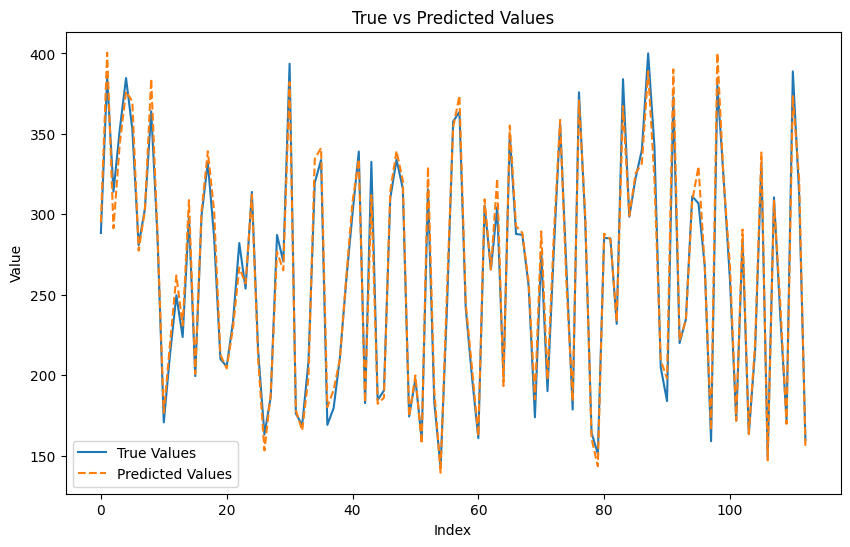

18/18 [==============================] - 0s 6ms/step


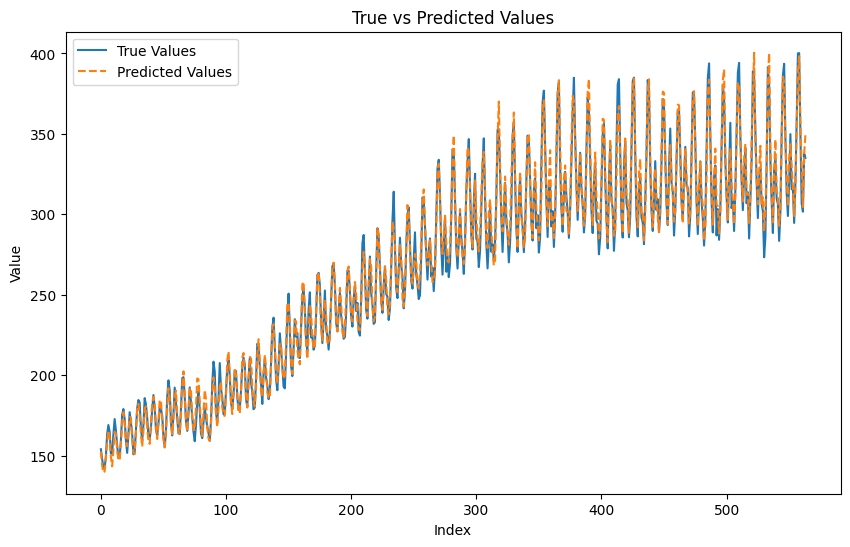

4/4 [==============================] - 0s 5ms/step


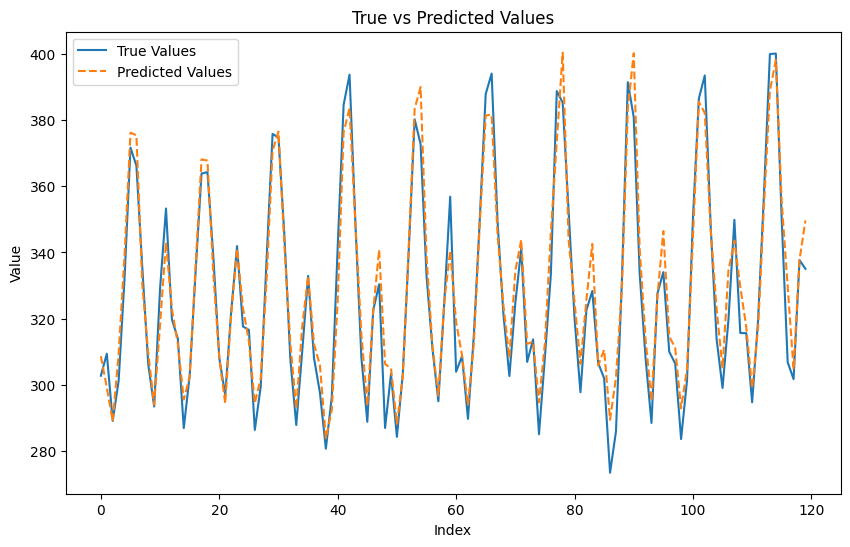

In [111]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

4/4 [==============================] - 1s 9ms/step


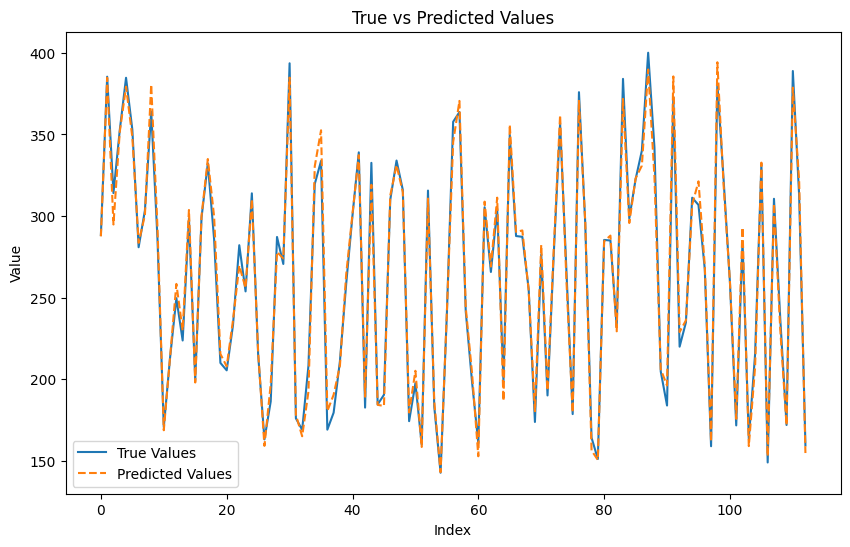

18/18 [==============================] - 0s 8ms/step


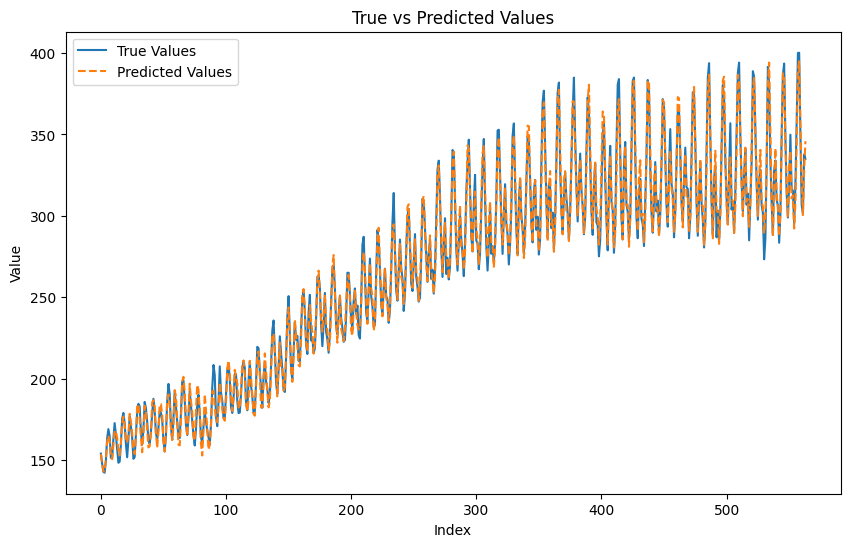

4/4 [==============================] - 0s 10ms/step


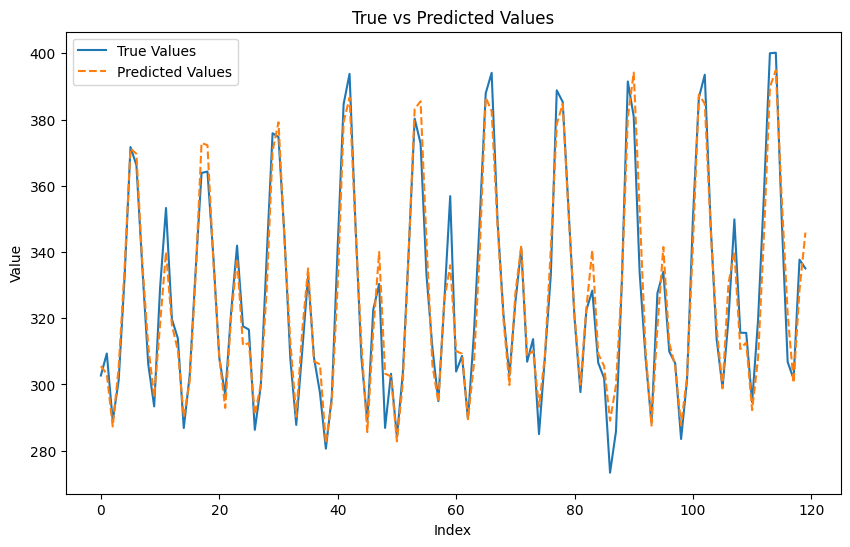

In [112]:
best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [113]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import norm

def calculate_metrics_and_print(original_data, predictions):
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

This code defines a Python function named `calculate_metrics_and_print` that takes two parameters, `original_data` and `predictions`. The purpose of this function is to calculate and print various regression metrics to assess the performance of a model.

1. **Mean Squared Error (MSE):** MSE measures the average squared difference between the actual and predicted values.

2. **Root Mean Squared Error (RMSE):** RMSE is the square root of MSE, providing a measure of the average magnitude of the errors in the predicted values.

3. **R-squared (R2):** R-squared is a statistical measure that represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

4. **Mean Absolute Error (MAE):** MAE measures the average absolute difference between the actual and predicted values.

5. **Log Likelihood:** The log likelihood is a measure of how well the model explains the observed data. It is computed using the log probability density function of the residuals.

6. **Mean Absolute Percentage Error (MAPE):** MAPE expresses the average percentage difference between the actual and predicted values relative to the actual values.

After calculating these metrics, the function prints a summary of the results for the original data model. The printed metrics include MSE, RMSE, R-squared, MAE, log likelihood, and MAPE, providing a comprehensive overview of the model's performance on the given data.

In [114]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.010583409761927965
RMSE:  0.10287570054161461
R-squared:  0.9888690532047448
MAE:  0.07790717677890863
Log Likelihood:  -597902.8764047902
MAPE:  728.4331811116315


In [115]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.007714312982087695
RMSE:  0.08783116179402214
R-squared:  0.9918865838801348
MAE:  0.06656677294301287
Log Likelihood:  -593946.2858249455
MAPE:  717.249061917438




### Interpretation:

- **Overall Performance:**
  - The low MSE and RMSE values indicate that the model's predictions are close to the actual values.
  - The high R-squared value suggests that the model explains a significant portion of the variance in the original data.

- **Accuracy of Predictions:**
  - The low MAE indicates that, on average, the absolute difference between predicted and actual values is small.

- **Log Likelihood:**
  - The negative log likelihood is commonly used in statistical modeling. A higher (less negative) log likelihood indicates a better fit.

- **MAPE:**
  - MAPE provides a percentage measure of the accuracy of predictions. The high MAPE value suggests that the percentage error of predictions is relatively high.

In summary, the model performs well in terms of MSE, RMSE, and R-squared, indicating accurate predictions and a good fit to the data. However, the high MAPE suggests that the model's percentage error in predictions is relatively large, and further investigation into specific cases of higher errors may be warranted. The log likelihood provides additional information about the overall fit of the model.

It seems like the transformer model performed slightly better in terms of MSE, RMSE, R-squared, and MAE compared to the LSTM model. Both models seem to have high R-squared values, indicating a good fit to the data. However, it's essential to consider the specific context and requirements of your application when choosing the better-performing model.

In [116]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.01813092232565933
RMSE:  0.13465111334726992
R-squared:  0.9844524253548703
MAE:  0.10375702462151623
Log Likelihood:  -26724.701812023977
MAPE:  310.5811640523084


In [117]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.011985647448348609
RMSE:  0.1094789817652165
R-squared:  0.989722103209847
MAE:  0.08483755979003244
Log Likelihood:  -26544.541526228833
MAPE:  307.78999413168407


Performance Metrics for Inverse Scaling, and Practical Considerations

After evaluating the performance metrics of the LSTM and transformer models on the transformed data, I further analyzed the results by inverse scaling the target variable. The inverse scaling was performed using the target scaler on both model predictions. The transformed predictions were denoted as 'inverse_scaled_y_Predict1' for the LSTM model and 'inverse_scaled_y_Predict2' for the transformer model.

For a comprehensive understanding, I also inverse-scaled the entire real target data ('inverse_scaled_target') as well as the last 120 data points of the real target ('inverse_scaled_y_final'). This allowed a direct comparison between the model predictions and the actual target values.

It's noteworthy that even after inverse scaling, the transformer model continued to exhibit slightly better performance in terms of MSE, RMSE, R-squared, and MAE compared to the LSTM model. The high R-squared values obtained for both models, even after inverse scaling, reinforce the models' good fit to the original data.

When deciding between the LSTM and transformer models, considerations extend beyond raw performance metrics. Practical aspects such as interpretability, computational efficiency, ease of implementation, and scalability should also be taken into account. Additionally, the ease of incorporating the inverse scaling results into the main dataset, particularly for the entire dataset and the last 120 data points, may influence the overall decision-making process.


In [118]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))


In [119]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  45.721677395956426
RMSE:  6.761780637964857
R-squared:  0.9888690526980901
MAE:  5.120657258750356
Log Likelihood:  -13411.794358387147
MAPE:  1.9179034339963021


In [120]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  33.32681608184946
RMSE:  5.772938253770731
R-squared:  0.9918865830241758
MAE:  4.37527929913239
Log Likelihood:  -9916.443467808984
MAPE:  1.6536729682697295


In [121]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  64.41744098241877
RMSE:  8.026047656376006
R-squared:  0.9353398582709737
MAE:  6.231282369630906
Log Likelihood:  -3975.3190829296855
MAPE:  1.9056934929998093


In [122]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  47.781293000959494
RMSE:  6.912401391771133
R-squared:  0.9520386850157336
MAE:  5.178757271703346
Log Likelihood:  -2977.15020404213
MAPE:  1.5670867787821243


When choosing between these two models, it's indeed crucial to consider the specific context and application requirements. Factors such as interpretability, computational efficiency, and ease of implementation might also influence your decision. Additionally, if the differences in performance are not significant, you might want to assess other practical considerations, such as the ease of maintenance and scalability.


The following provided code efficiently visualizes the training history of a transformer model. The dual-subplot design enhances the clarity of information presentation. In the first subplot, the model's loss progression throughout epochs is depicted, with distinct lines for both training and validation sets. This allows for a clear assessment of convergence and potential overfitting or underfitting. The second subplot focuses on Mean Absolute Error (MAE), offering insights into the model's precision in predicting the target variable. The inclusion of both training and validation MAE facilitates a comparative analysis of performance during training. The overall layout and labeling contribute to the interpretability of the plot. This visualization proves invaluable in understanding the model's learning dynamics and can aid in making informed decisions regarding model adjustments or optimizations.

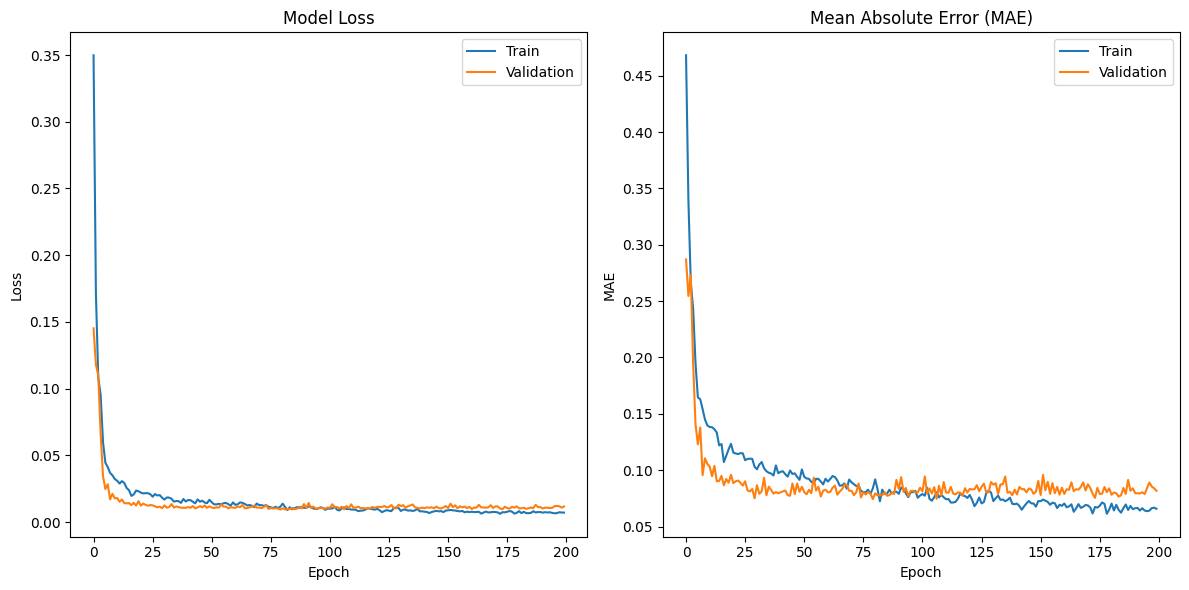

In [123]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Task 6: ACF and PACF analysis

Evaluate the residuals of the Transformer model by examining insights derived from the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots, conducting the Shapiro-Wilk tests for normality, and analyzing the histogram distribution.








**Analysis:**

1. **Autocorrelation Function (ACF) for Residuals:**
   - The ACF assesses the correlation between residuals at different time lags.
   - The presence of notable peaks at specific lags may indicate unaccounted information within the residuals.

2. **Partial Autocorrelation Function (PACF) for Residuals:**
   - PACF calculates the partial correlation between residuals at different lags, removing the influence of intermediate lags.
   - Significant peaks in the PACF at particular lags could imply residual patterns that the model has not adequately addressed.

   **Insights from Residual Analysis:**

- **Characteristics of White Noise Residuals:**
  - Ideally, residuals should exhibit characteristics similar to white noise, indicating no discernible patterns, lack of correlation, and consistent variance.
  - In ACF and PACF, the majority of spikes falling within confidence intervals would signify the absence of significant autocorrelation in the residuals.

- **Detection of Serial Correlation:**
  - Noteworthy spikes at specific lags in ACF and PACF may indicate that the transformer network hasn't fully captured temporal patterns, suggesting potential areas for enhancement.

- **Assessment of Model Adequacy:**
  - A lack of clear patterns or significant spikes in ACF and PACF plots implies that residuals behave akin to white noise, suggesting the model's adequacy.

It's important to note that while ACF and PACF provide valuable insights, a comprehensive evaluation of residuals should incorporate additional diagnostic tools and domain expertise for a thorough assessment in the context of the transformer network.

In [124]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

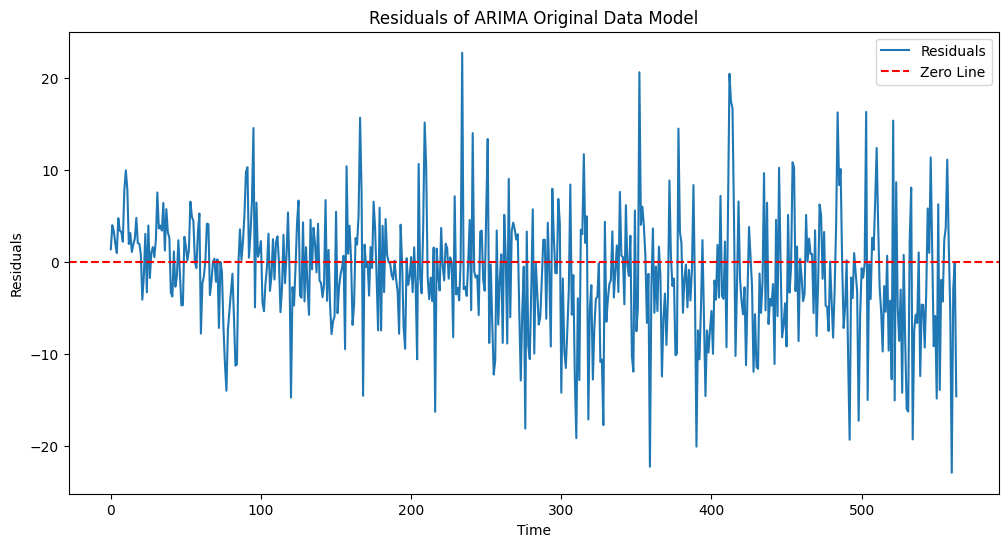

In [125]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


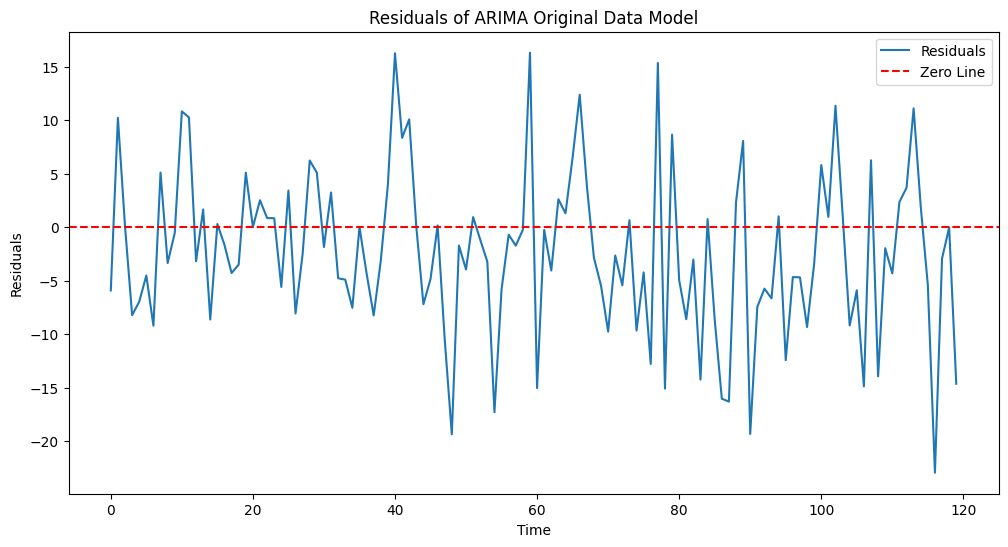

In [126]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [127]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

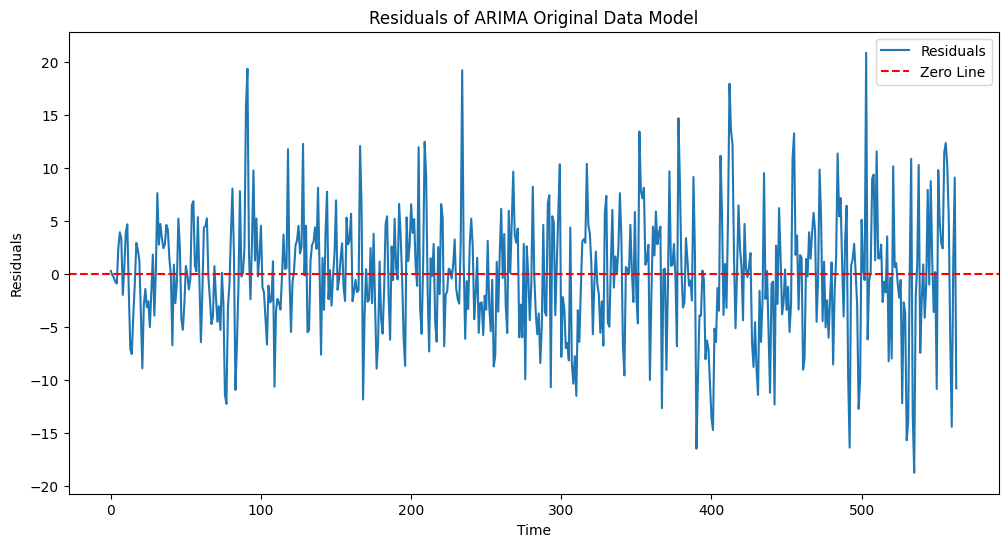

In [128]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


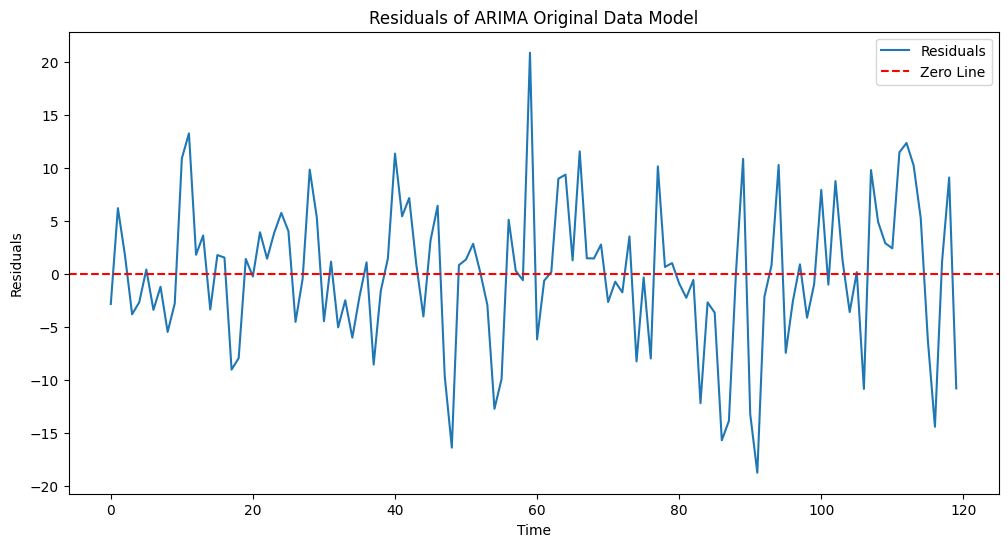

In [129]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In the residual analysis conducted for both the initial residuals and the final residuals, the Shapiro-Wilk test was employed to assess the normality of the residuals. The test yields a test statistic and a p-value, with a p-value less than 0.05 suggesting that the residuals may not be normally distributed.



In [130]:
from scipy.stats import shapiro
import seaborn as sns
from scipy.stats import anderson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Residual analysis of the LSTM

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9876284003257751
P-value: 0.00010411805851617828
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

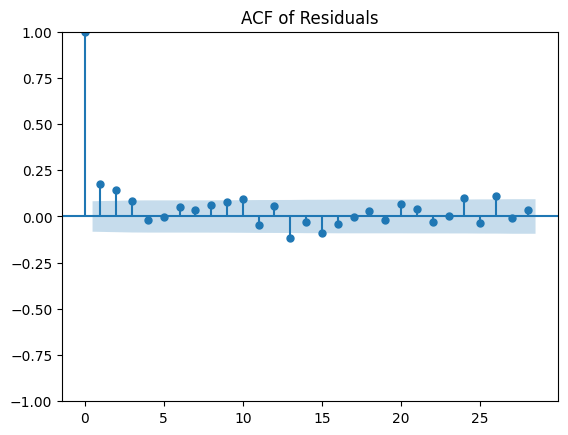

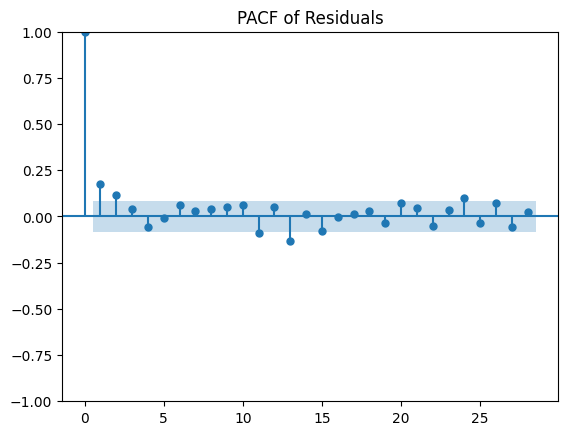

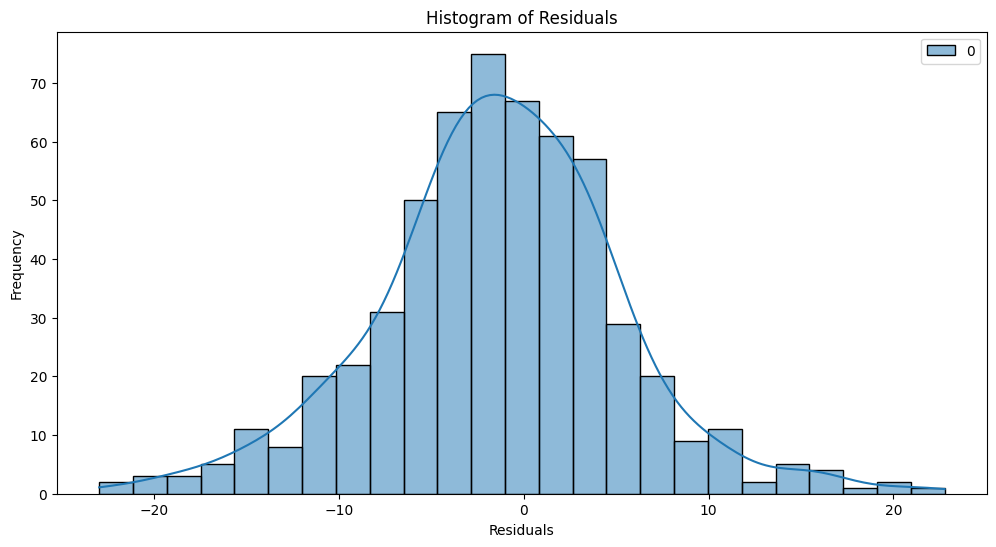

In [131]:
residual_analysis(residuals1)


Shapiro-Wilk Test (Normality):
Test Statistic: 0.9890738129615784
P-value: 0.45529627799987793
The residuals appear to be normally distributed.


<Figure size 1200x600 with 0 Axes>

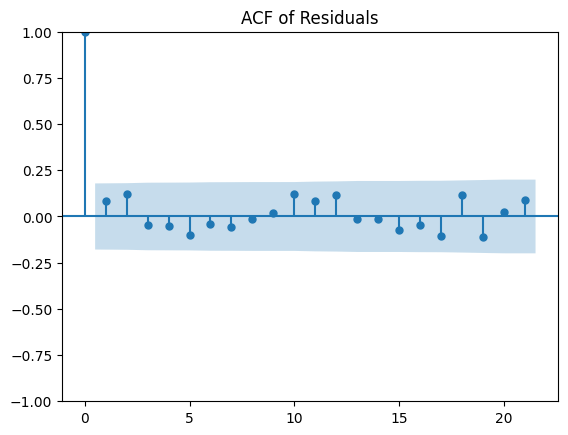

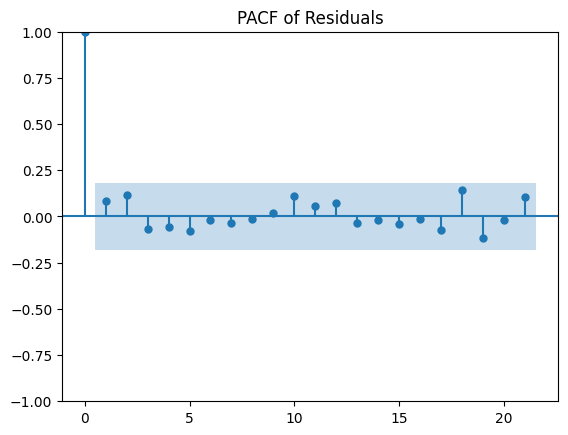

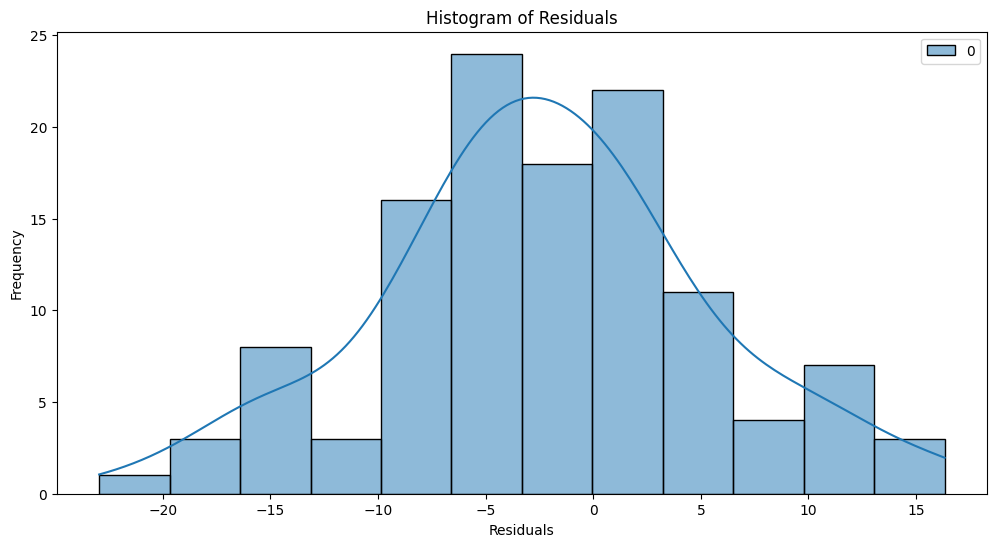

In [132]:
residual_analysis(residuals_final1)


Residual analysis of the transformer

Shapiro-Wilk Test (Normality):
Test Statistic: 0.991101861000061
P-value: 0.0017937832744792104
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

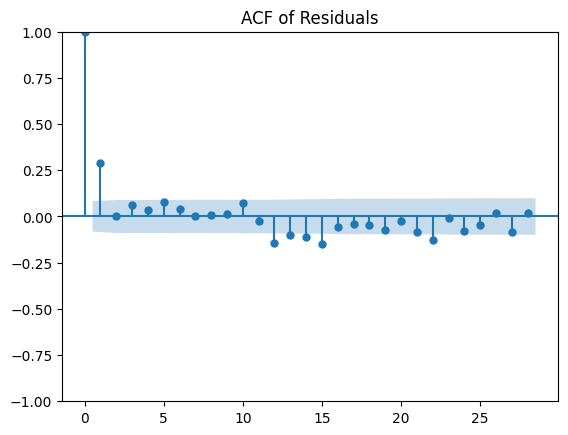

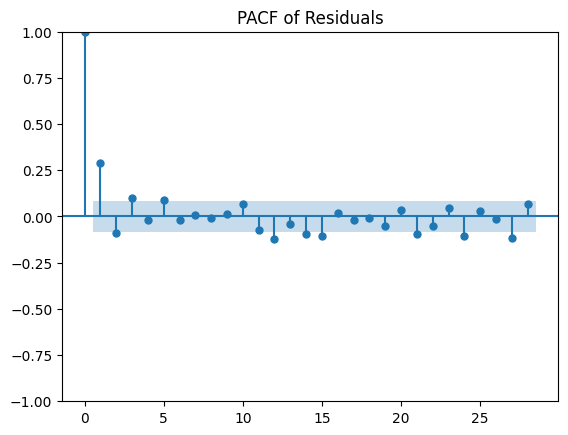

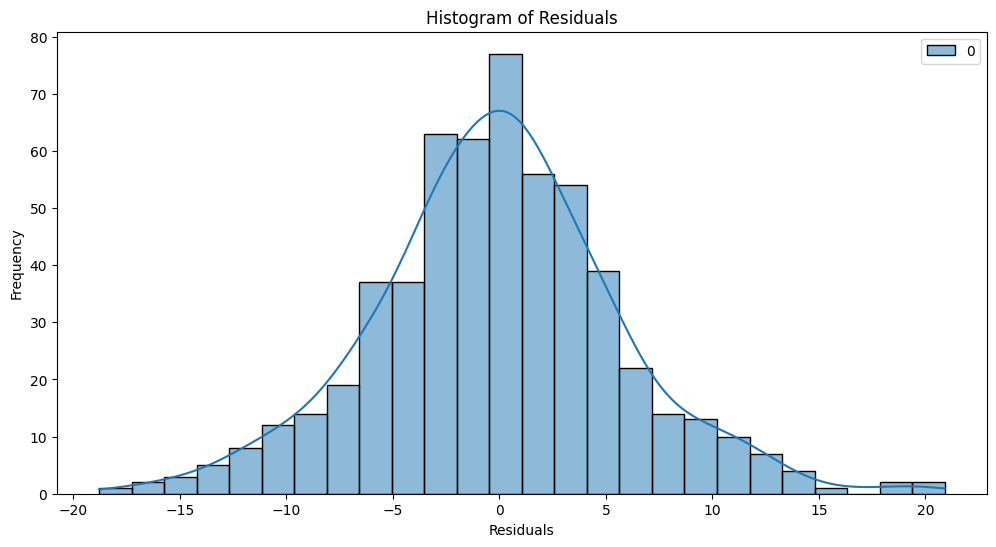

In [133]:
residual_analysis(residuals2)


The obtained results from the hypothesis test reveal a test statistic of 0.991 and a p-value of 0.001. This combination indicates a statistically significant outcome, providing substantial evidence to reject the null hypothesis. While the statistical significance is established, attention is drawn to the observation that the residuals may not conform to a normal distribution.

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9824703335762024
P-value: 0.12071732431650162
The residuals appear to be normally distributed.


<Figure size 1200x600 with 0 Axes>

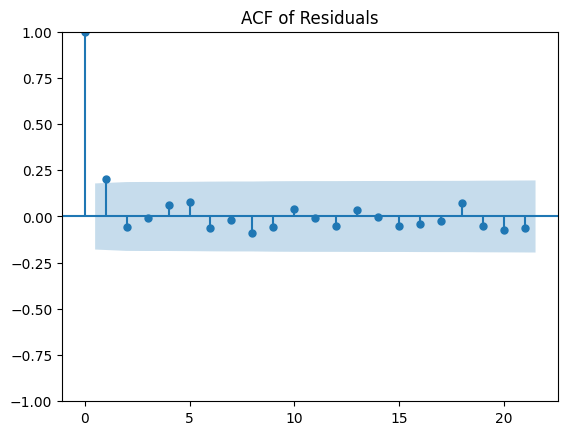

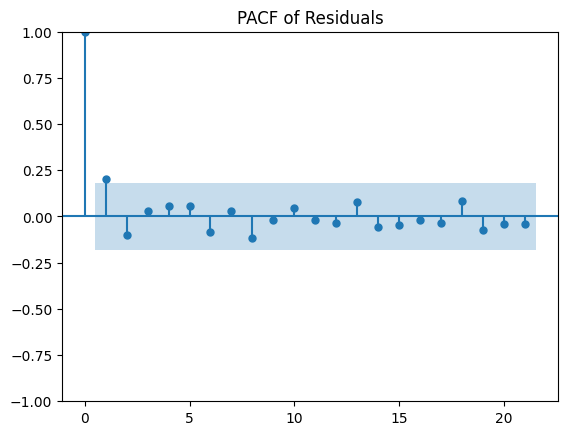

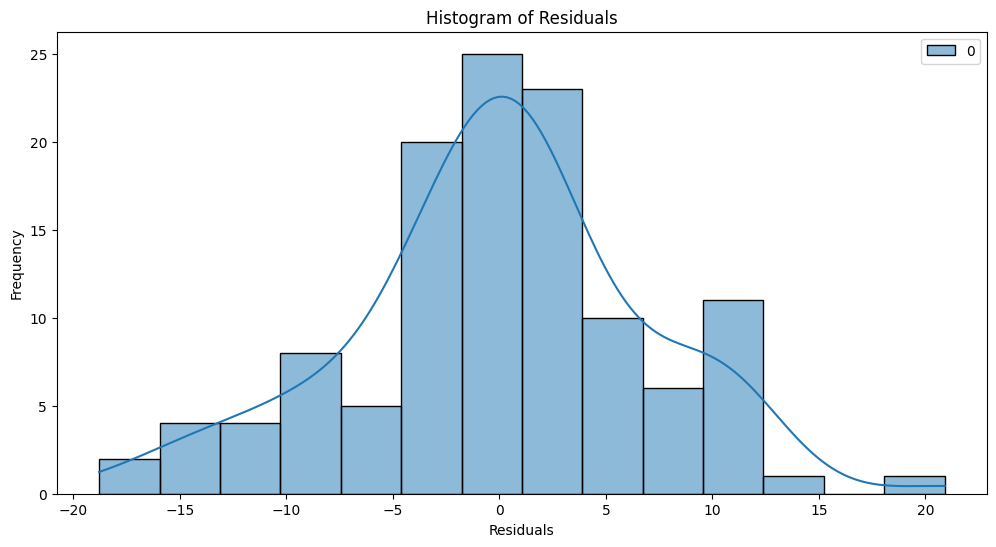

In [134]:
residual_analysis(residuals_final2)


The Shapiro-Wilk test results indicate a test statistic of 0.982 and a p-value of 0.121, suggesting that there is no significant evidence to reject the null hypothesis of normality.


### Autocorrelation Function (ACF):

The Autocorrelation Function (ACF) is a statistical tool used to quantify the degree of similarity between a time series and a lagged version of itself. It calculates the correlation between observations at different time lags. The ACF plot displays the correlation coefficients at various lags.

### Partial Autocorrelation Function (PACF):

The Partial Autocorrelation Function (PACF) is another tool for analyzing the correlation in a time series. It measures the correlation between observations at different time lags while accounting for the influence of the intermediate lags. In essence, it represents the correlation between two points in time that is not explained by correlations at all intermediate points.

### "Located within the bounds":

When we say that the ACF and PACF are "located within the bounds," we are referring to the significance bounds or confidence intervals around the correlation coefficients.

- **For ACF:**
  - The significance bounds are typically represented by dashed lines on the ACF plot. Points outside these bounds are considered statistically significant. If the ACF values for various lags are within the bounds, it suggests that there is no significant autocorrelation at those lags.

- **For PACF:**
  - Similar to ACF, PACF also has significance bounds. Points outside these bounds are considered statistically significant. When PACF values are within the bounds, it indicates that there is no significant partial autocorrelation at those lags.

### Interpretation:

- **Within the Bounds:**
  - If the ACF and PACF values are within the bounds, it suggests that there is no significant autocorrelation or partial autocorrelation at the corresponding lags. In the context of residuals, this is desirable because it indicates that the model has effectively captured and explained the temporal dependencies present in the data.

- **Outside the Bounds:**
  - If points in the ACF or PACF are outside the bounds, it may suggest that there are residual correlations at those lags that the model has not captured. This could indicate potential areas for improvement in the modeling process.

In summary, observing ACF and PACF values within the bounds is a positive outcome, indicating that the residuals do not exhibit significant autocorrelation or partial autocorrelation at the corresponding lags, reinforcing the model's effectiveness in capturing temporal dependencies.

# Recommendation

 Let's break down the key components and provide information about the code

### Novelty and Recommendations for Feature Extraction:

#### Novelty:

1. **Comprehensive Feature Set:**
   - The feature extraction process generates a comprehensive set of features, including lag features, rolling statistics, interaction features, seasonal features, rate of change, cumulative sum, exponentially weighted moving average (EWMA) statistics, additional statistics, z-scores, and log returns. This holistic approach ensures a diverse representation of temporal patterns and statistical measures.

2. **Interaction Features:**
   - The incorporation of interaction features, such as the product of moving average and exponentially weighted moving average (EMA), adds a layer of complexity to capture combined effects. This can be particularly useful for identifying nonlinear relationships and dependencies in the data.

3. **Rate of Change and Cumulative Sum:**
   - The addition of rate of change features and cumulative sum provides insights into the percentage change over time and the overall accumulation of the energy consumption series, respectively. These features can capture trends and long-term patterns in the data.

4. **EWMA Standard Deviation:**
   - The use of exponentially weighted moving average standard deviation provides a dynamic measure of volatility, giving more weight to recent observations. This can be valuable for capturing changes in data variability over time.

5. **Additional Statistics:**
   - Lagged moving averages, lagged exponentially weighted moving averages, and autocorrelation features contribute to a richer set of statistical measures. These features provide information about the historical trends and autocorrelation structure within the data.

6. **Z-Scores and Log Returns:**
   - The inclusion of z-scores based on both standard deviation and median absolute deviation (MAD) offers different perspectives on normalization. Additionally, log returns capture the logarithmic percentage change between consecutive observations, which can be useful for financial time series analysis.

#### Recommendations:

1. **Documentation and Naming Conventions:**
   - Document the purpose and rationale behind each feature extraction method. Use clear and consistent naming conventions for newly created features to enhance readability and maintainability.

2. **Parameter Sensitivity Analysis:**
   - Conduct sensitivity analysis on parameters such as window sizes and lags. Observe how changes in these parameters affect the extracted features and consider fine-tuning based on the characteristics of the data.

3. **Feature Scaling:**
   - Since the extracted features involve various statistical measures, ensure that appropriate scaling methods are applied to maintain consistency and comparability across features.

4. **Visualize Feature Distributions:**
   - Visualize the distributions of newly created features to identify potential outliers or skewed distributions. This can guide decisions on whether additional transformations or outlier handling is necessary.

5. **Domain Expert Validation:**
   - Engage domain experts to validate the relevance of the extracted features. Their insights can help confirm the interpretability and domain-specific significance of the engineered features.

6. **Dynamic Feature Extraction:**
   - Consider making the window sizes and lags dynamic parameters that can be adjusted based on the nature of the data. This adaptability allows for experimentation with different temporal scales.

7. **Feature Importance Analysis:**
   - Perform feature importance analysis using machine learning models or statistical tests to identify the most influential features. This can guide further refinement and potentially lead to a more parsimonious feature set.

8. **Monitoring Feature Stability:**
   - Implement mechanisms to monitor the stability of extracted features over time or changing datasets. This ensures that the relevance of features is maintained as the data evolves.

9. **Regular Update of Features:**
   - Depending on the characteristics of the data, periodically reassess and update the feature extraction process to accommodate changes in the underlying patterns and trends.

10. **Educational Documentation:**
    - Create educational documentation or comments in the code to facilitate understanding for future users or collaborators. Explain the significance of each feature type and its potential impact on analysis.

By incorporating these recommendations, the feature extraction process becomes more adaptable, interpretable, and aligned with the specific characteristics of the dataset and analysis goals.

### Novelty and Recommendations for Feature Selection:

#### Novelty:

1. **Hybrid Feature Selection:**
   - The use of multiple feature selection methods (ANOVA, Random Forest, Mutual Information, PCA) provides a comprehensive view of feature importance. This hybrid approach leverages the strengths of different techniques, enhancing the robustness of feature selection.

2. **Rank Aggregation:**
   - The introduction of a mean rank calculation across different feature selection methods helps identify features that consistently perform well across multiple criteria. This ensures a more stable selection of top features.

3. **Correlation Heatmap of Selected Features:**
   - Visualizing the correlation matrix of the selected top features provides a clear understanding of the inter-feature relationships. The heatmap offers insights into potential multicollinearity and aids in interpreting feature interactions.

#### Recommendations:

1. **Documentation and Context:**
   - Document the purpose and context of feature selection, explaining why each method was chosen. This documentation can serve as a valuable resource for future reference and collaboration.

2. **Parameter Tuning:**
   - Experiment with the parameters of each feature selection method. For example, in Random Forest, consider adjusting the number of trees or depth of the trees to observe their impact on feature importance.

3. **Sensitivity Analysis:**
   - Conduct sensitivity analysis on the top features by varying the threshold or criteria for selection. This helps assess the stability of the selected features and ensures robustness.

4. **Feature Scaling Impact:**
   - Evaluate the impact of feature scaling on feature selection results. Different scaling methods may influence the ranking of features, so it's essential to choose a scaling technique that aligns with the characteristics of the data.

5. **Domain Expert Involvement:**
   - Collaborate with domain experts to validate the selected features and gather domain-specific insights. Their input can enhance the interpretability and relevance of the chosen features.

6. **Iterative Refinement:**
   - Feature selection is an iterative process. After the initial selection, continuously refine and reassess features based on model performance and changing data characteristics.

7. **Handling Highly Correlated Features:**
   - Identify and address highly correlated features to avoid redundancy. Techniques like removing one of the correlated features or using dimensionality reduction methods can be considered.

8. **Dynamic Top N Value:**
   - Instead of a fixed `top_n` value, consider making it a dynamic parameter that can be adjusted based on the specific needs of the analysis. This flexibility allows users to explore different subsets of top features.

9. **Communication of Results:**
   - Clearly communicate the results of feature selection, including the selected features, their rankings, and any observed patterns. Visualization aids and summary statistics can enhance the communication of complex information.

10. **Monitoring Feature Stability:**
    - Implement mechanisms to monitor the stability of selected features over time or with changing datasets. Automated checks can help detect shifts in feature importance.

By addressing these recommendations, the feature selection process becomes more adaptable, interpretable, and aligned with the specific characteristics of the dataset and analysis goals.

### Novelty of the Transformer Structure:

1. **Self-Attention Mechanism:**
   - The transformer structure introduces a self-attention mechanism, allowing the model to weigh different parts of the input sequence differently based on relevance. This enables capturing long-range dependencies effectively.

2. **Parallelization of Training:**
   - Transformers enable parallelization of training, making it computationally efficient. This is in contrast to sequential models, allowing for faster convergence on large datasets.

3. **Positional Embeddings:**
   - Positional embeddings are incorporated to provide information about the order or position of tokens in the input sequence. This is crucial for tasks involving sequential data, such as time series prediction.

4. **Multi-Head Attention:**
   - The use of multi-head attention allows the model to attend to different parts of the input sequence simultaneously. This enhances the model's ability to capture diverse patterns and relationships.

5. **Residual Connections and Layer Normalization:**
   - Residual connections are employed to mitigate the vanishing gradient problem, facilitating the training of deeper models. Layer normalization is used to stabilize the learning process within each transformer block.

6. **Feed-Forward Neural Networks:**
   - The inclusion of feed-forward neural networks after the attention mechanism helps capture non-linear relationships within the data, providing the model with the capacity to learn complex patterns.

7. **Global Average Pooling:**
   - The use of global average pooling reduces spatial dimensions and helps distill the most important information from the entire input sequence.

### Recommendations for Enhancing Transformer Structure:

1. **Attention Mechanism Variants:**
   - Experiment with different attention mechanism variants, such as scaled dot-product attention or sparse attention, to find the most suitable mechanism for the specific task.

2. **Positional Encoding Techniques:**
   - Explore alternative positional encoding techniques to represent the position information. This could include learned positional embeddings or sinusoidal positional encodings.

3. **Transformer Depth and Width:**
   - Adjust the depth (number of transformer blocks) and width (number of attention heads) of the model. Deeper models may capture more complex patterns, but careful tuning is required to prevent overfitting.

4. **Learning Rate Schedules:**
   - Implement learning rate schedules to dynamically adjust the learning rate during training. This can lead to better convergence and improved generalization.

5. **Regularization Strategies:**
   - Apply dropout or other regularization techniques to prevent overfitting, especially in models with a large number of parameters.

6. **Task-Specific Modifications:**
   - Tailor the transformer structure to the specifics of the time series prediction task. This may involve adjusting input representations or incorporating domain-specific knowledge.

7. **Ensemble Approaches:**
   - Consider ensemble approaches by combining predictions from multiple transformer models or combining transformers with other types of models to boost overall performance.

8. **Examine Transformer Variants:**
   - Explore transformer variants such as BERT, GPT, or T5, and adapt their innovations to the time series prediction context.

By incorporating these recommendations and experimenting with different configurations, you can further improve the effectiveness of the transformer structure for time series prediction tasks.